In [1]:
# importing relevant modules
import matplotlib.pyplot   as plt

from pandas                import read_csv, to_datetime
from numpy                 import reshape
from datetime              import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.layers          import Dense, Dropout, LSTM, Input
from keras.models          import Model
from keras_tqdm            import TQDMNotebookCallback
from IPython.display       import SVG, display
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Choose a csv file to read. The data files are kept in the dataFiles list and the 'file'
# parameter corresponds to the index of the dataFiles array. The default file value corresponds
# to the bitflyer data set, which happens to be the smallest data set for and is nice for quick
# training. The 'split' parameter determines how to partition the data set into training and testing
# sets. The default value of 0.2 says to us 80% of the data set for training and the remaining 20% for
# testing. This function will return the training and testing sets (in that order) as well as the
# fitted min-max scaler so that we can perform the inverse operations for plotting. If the 'reduce' 
# parameter is specified, then the data set will be reduced to the size of the parameter by chopping
# off the first len(daily_avergae) - reduce values. The return value will then be the partitioned
# reduced data sets and the fitted min-max scaler.
def Read_File(file: int = 0, split: float = 0.2, reduce: int = 0):          #File size (in MB)
    dataFiles     = ['bitflyerJPY_1-min_data_2017-07-04_to_2018-03-27.csv',  #28
                     'coinbaseUSD_1-min_data_2014-12-01_to_2018-03-27.csv',  #116
                     'coincheckJPY_1-min_data_2014-10-31_to_2018-03-27.csv', #114
                     'bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv'   #212
                    ]
    df            = read_csv('../data/' + dataFiles[file])
    
    # Append 'date' column to our dataframe.
    df['date']    = to_datetime(df['Timestamp'],unit='s').dt.date
    
    # Store the average weighted price per day (in USD).
    daily_average = [df.groupby('date')['Weighted_Price'].mean().apply(lambda p: p*0.0094),
                     df.groupby('date')['Weighted_Price'].mean()][file%2].values
    
    #reduce file, if desired.
    if reduce and reduce < len(daily_average):
        daily_average = daily_average[len(daily_average) - 1 - reduce:]
        
    #Gaurantees at least one testing example.
    partition     = min(-int(split*len(daily_average)), -1)
    
    training_set, testing_set = daily_average[:partition], daily_average[partition:]
    
    # Create instance of min-max scaler.
    sc                        = MinMaxScaler(feature_range = (0, 1))
    
    # Reshape training and testing sets and then perform min-max scaling.
    training_set, testing_set = sc.fit_transform(reshape(training_set, (len(training_set), 1))), sc.transform(reshape(testing_set, (len(testing_set), 1)))
    
    return training_set[:-1], training_set[1:], testing_set[:-1], testing_set[1:], sc

In [3]:
#Plot results.
def Plot(data1, data2, title, label1, label2, ylabel, scatter = True):
    plt.figure(figsize   = (25,15),
               dpi       = 80,
               facecolor = 'w',
               edgecolor = 'k')
    
    ax = plt.gca()

    x  = [_ for _ in range(len(data1))]
    
    if scatter:
        plt.plot(data1, 
                 color = '#AA00FF',
                 ls    = 'dashed')
        plt.plot(data2,
                 color = '#000000',
                 ls    = 'dashed')
        plt.scatter(x,
                   data1,
                   label = label1,
                   color = '#AA00FF',
                   s     = 50)
        plt.scatter(x,
                   data2,
                   label = label2,
                   color = '#000000',
                   s     = 50)
    else:
        plt.bar(x,
                reshape(data1, (len(data1))),
                label = label1,
                color = '#AA00FF')
        plt.bar(x,
                reshape(data2, (len(data2))),
                label = label2,
                color = '#000000',
                alpha = 0.5)

    plt.title(title,
              fontsize = 40)

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(18)

    plt.xlabel('Time (days)',
               fontsize = 40)
    plt.ylabel(ylabel,
               fontsize = 40)
    plt.legend(loc  = 'best',
               prop = {'size': 25})

    plt.show()

In [4]:
# Get percent change results for plotting.
Get_Percent_Change = lambda p: [100*(e2 - e1)/e1 for e1, e2 in zip(reshape(p[:-1], p[:-1].shape), reshape(p[1:], p[1:].shape))]

We will now perform min-max scaling on the training data and then construct an LSTM network to make predictions for the remainder of our data. After this, we will compare our model's predicted price values to that of the testing data set.

In [5]:
# Create training/testing arrays and store min-max scaler so we can perform inverse transform later.
x_train, y_train, x_test, y_test, sc = Read_File()

#Reshape the training and testing input so that it meets the specifications of the net input.
x_train                              = reshape(x_train, (len(x_train), 1, 1))
x_test                               = reshape(x_test, (len(x_test), 1, 1))

In [6]:
# Building the model
lstm_units  = 100
inputs      = Input(shape = x_train[0].shape)

layer       = LSTM(units            = lstm_units,
                   return_sequences = True,
                   activation       = 'selu')(inputs)

layer       = Dropout(0.2)(layer)

layer       = LSTM(units            = lstm_units,
                   return_sequences = False,
                   activation       = 'selu')(layer)

layer       = Dropout(0.2)(layer)

predictions = Dense(units      = 1,
                    activation = 'linear')(layer)

model       = Model(inputs, predictions)

model.compile(loss      = 'mean_squared_error',
              optimizer = 'adadelta')

# Visual representation of net.
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
# Fitting the RNN to the Training set
history = model.fit(x                = x_train,
                    y                = y_train,
                    batch_size       = len(x_train),
                    epochs           = 100,
                    validation_split = 0.2,
                    verbose          = 0,
                    shuffle          = False,
                    callbacks        = [TQDMNotebookCallback()])

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=168), HTML(value='')))

In [8]:
# Comparing our model's output, given the training data, to the expected output.
actual_prices_train       = sc.inverse_transform(y_train)[:-1]
predicted_BTC_price_train = sc.inverse_transform(model.predict(x_train))[1:]

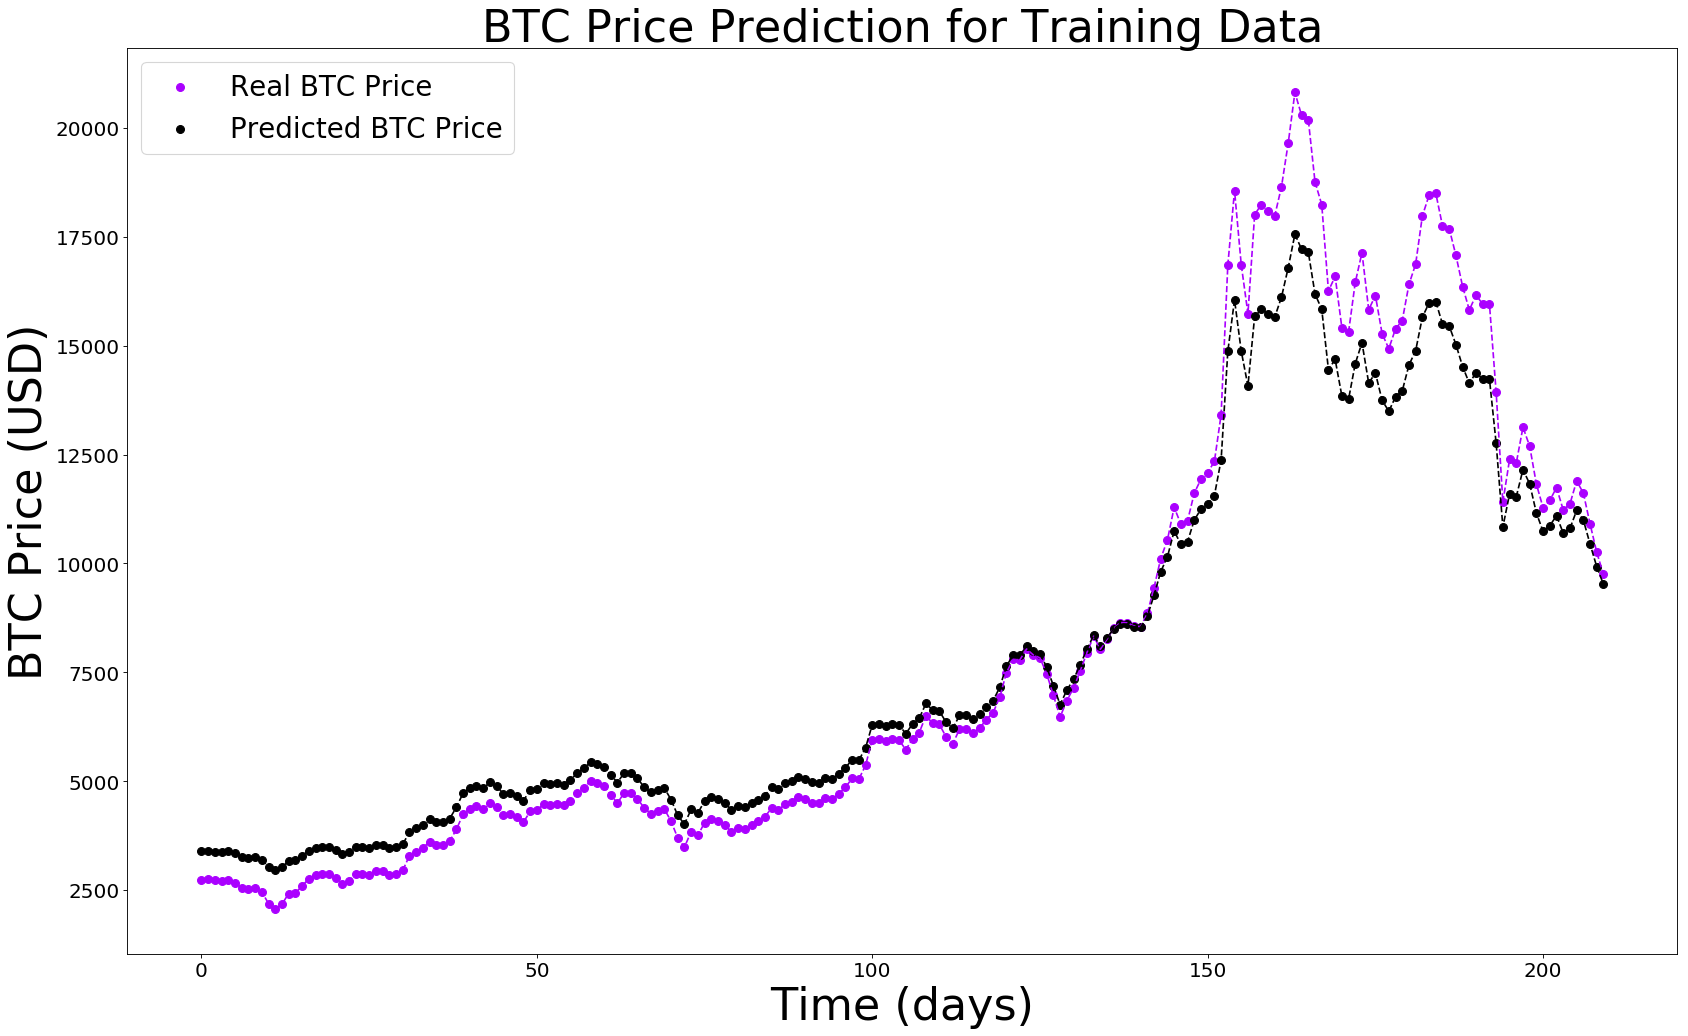

In [9]:
Plot(actual_prices_train, predicted_BTC_price_train, "BTC Price Prediction for Training Data", "Real BTC Price", "Predicted BTC Price", "BTC Price (USD)")

Even more interesting than looking at the average daily price prediction is looking at the predicted average daily price percent change as compared to that of the actual average daily price percent change; we will do this below.

In [10]:
predicted_percent_change_train = Get_Percent_Change(predicted_BTC_price_train)
actual_percent_change_train    = Get_Percent_Change(actual_prices_train)

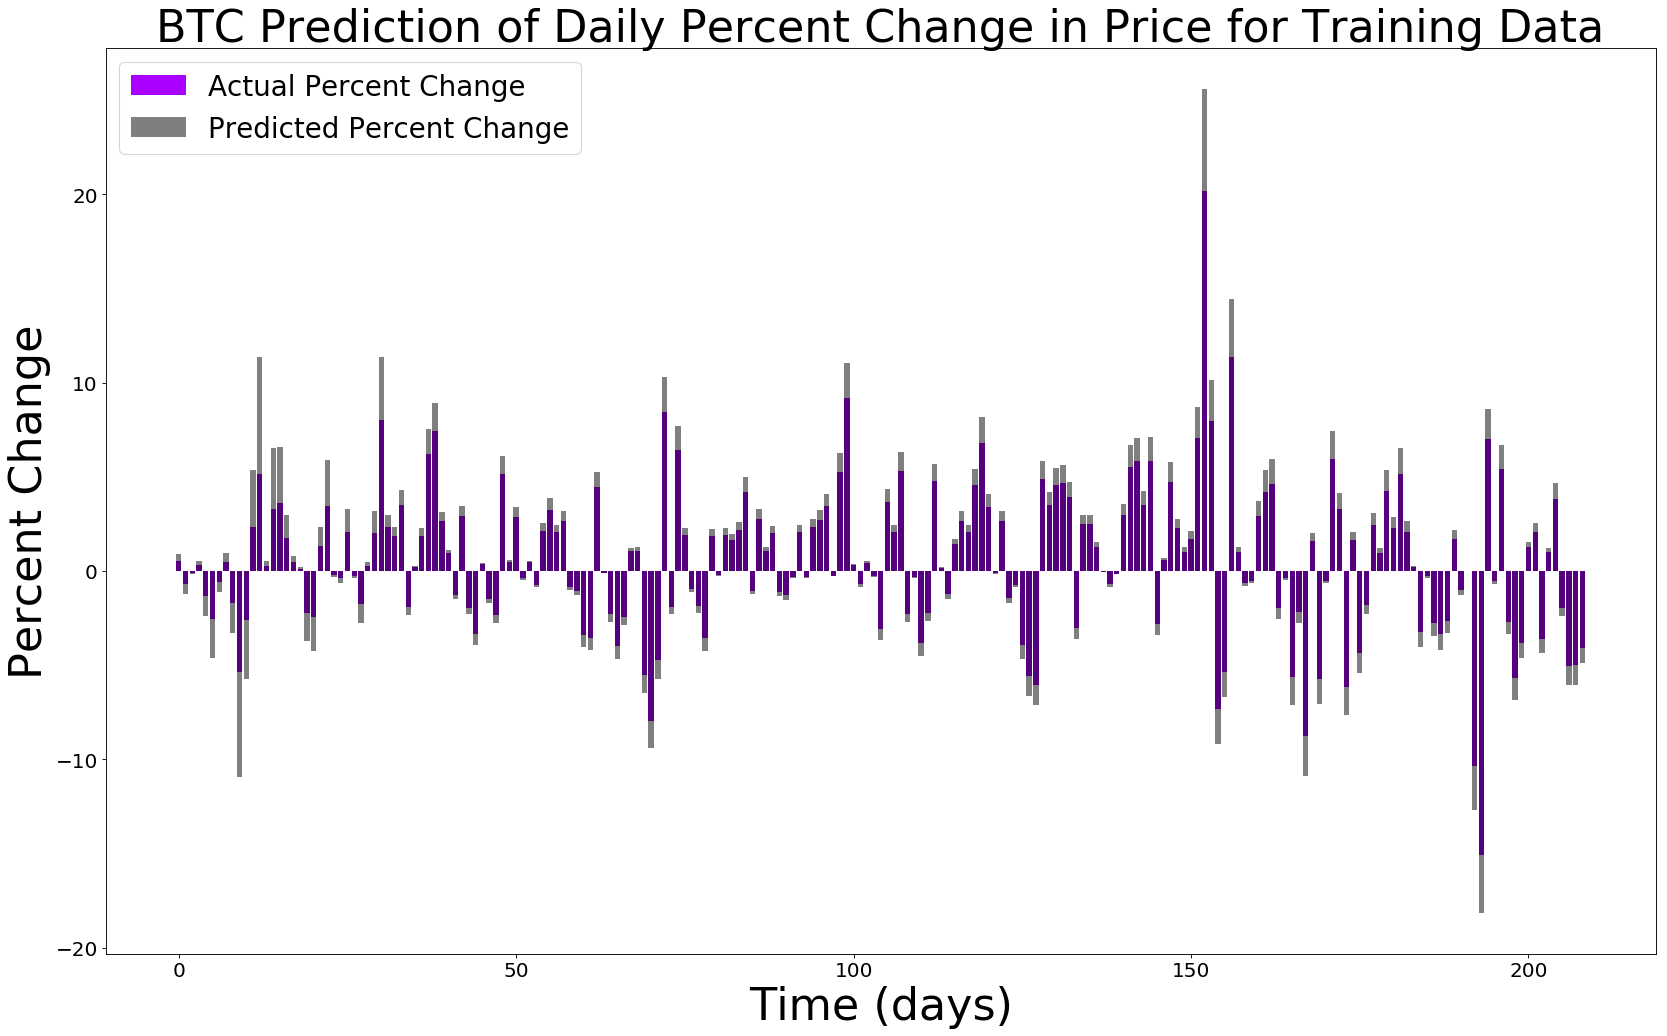

In [11]:
Plot(predicted_percent_change_train, actual_percent_change_train, "BTC Prediction of Daily Percent Change in Price for Training Data", "Actual Percent Change", "Predicted Percent Change", "Percent Change", False)

In [12]:
#Predicting the future.
actual_prices_test       = sc.inverse_transform(y_test)[:-1]
predicted_BTC_price_test = sc.inverse_transform(model.predict(x_test))[1:]

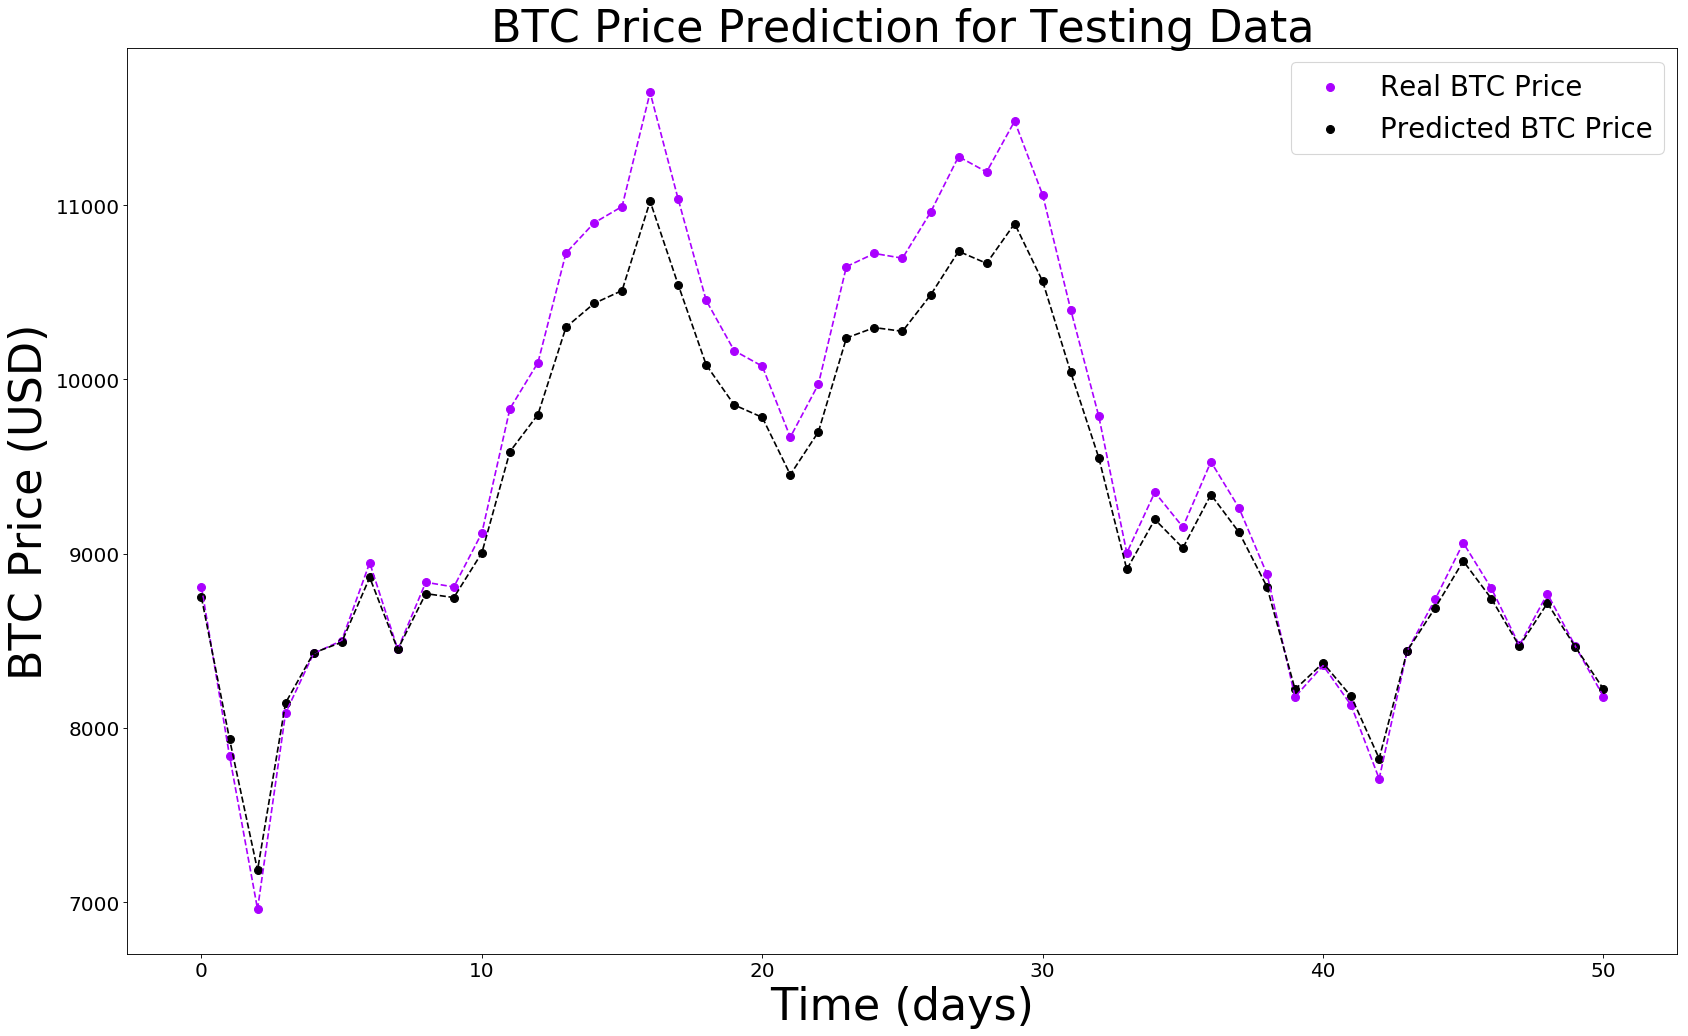

In [13]:
Plot(actual_prices_test, predicted_BTC_price_test, "BTC Price Prediction for Testing Data", "Real BTC Price", "Predicted BTC Price", "BTC Price (USD)")

In [14]:
predicted_percent_change_test = Get_Percent_Change(predicted_BTC_price_test)
actual_percent_change_test    = Get_Percent_Change(actual_prices_test)

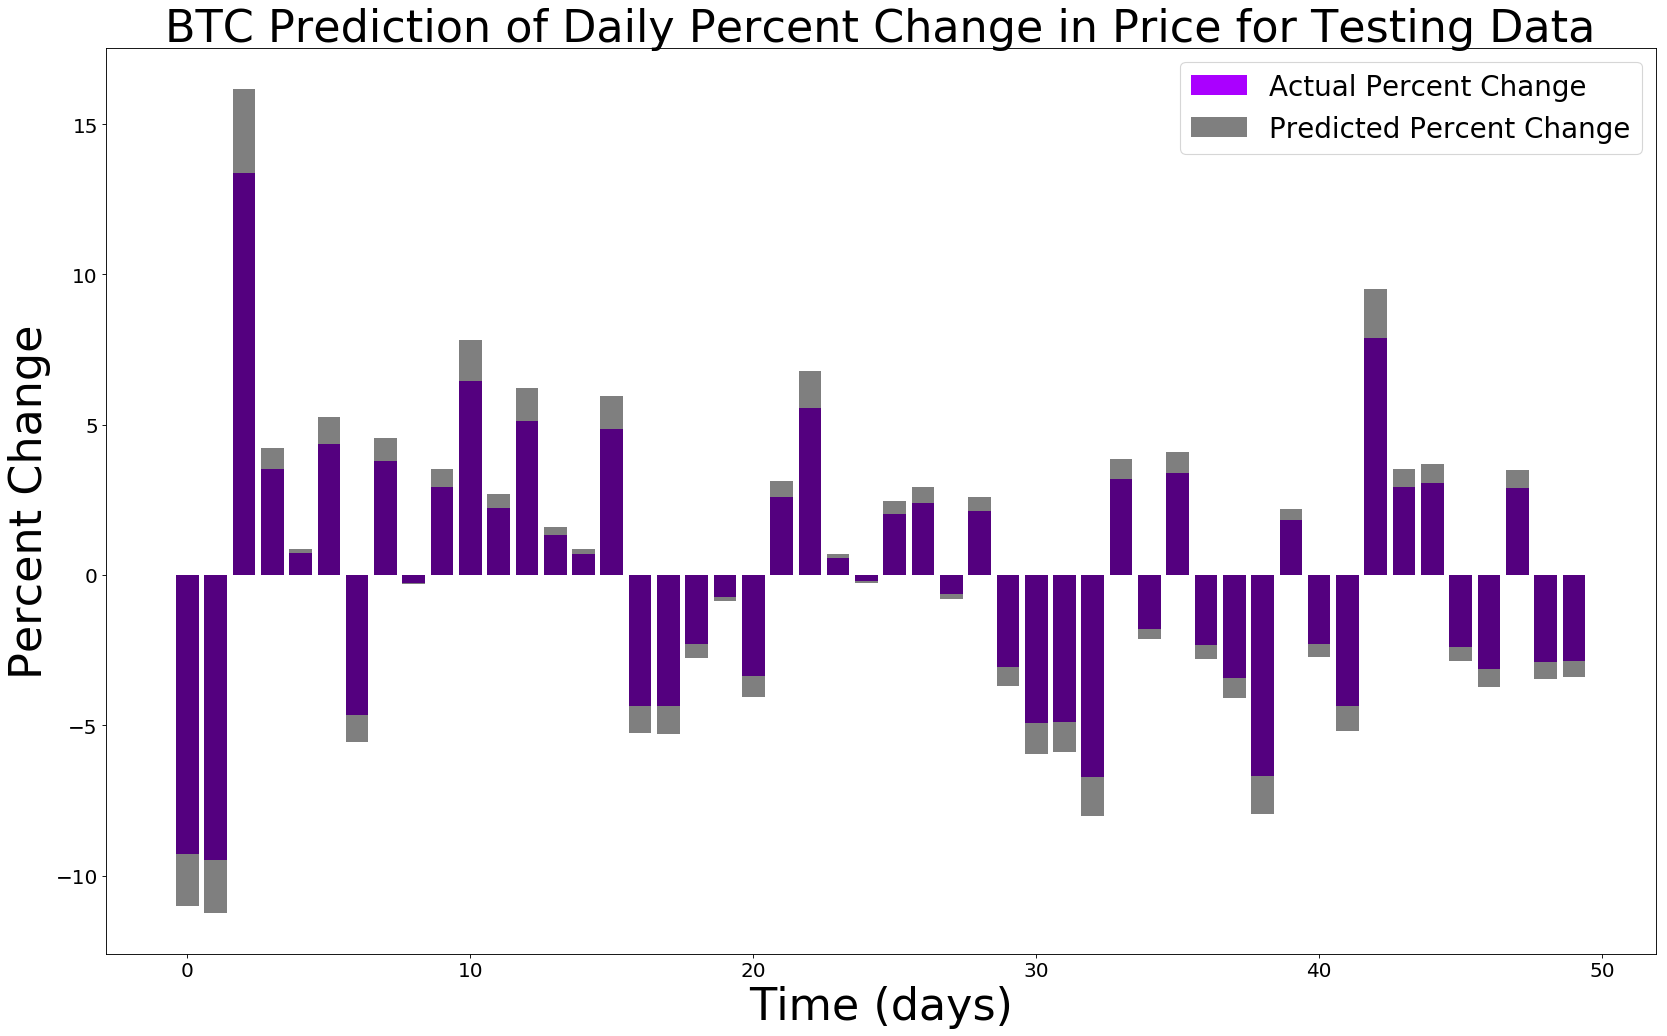

In [15]:
Plot(predicted_percent_change_test, actual_percent_change_test, "BTC Prediction of Daily Percent Change in Price for Testing Data", "Actual Percent Change", "Predicted Percent Change", "Percent Change", False)